In [11]:
import pandas as pd
import numpy as np
import os
import time
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from selenium import webdriver
from selenium.webdriver.common.by import By
import re
from selenium.webdriver.common.keys import Keys
import requests
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime 

In [12]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('disable-infobars')
chrome_options.add_argument('--disable-notifications')
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option('useAutomationExtension', False)
chrome_options.add_argument('--disable-popup-blocking')

In [71]:
class crypto_ann_price_analyzer:
    
    def __init__(self):
        
        self.currency = 0
        self.num_of_days_before = 0
        self.dataframe = 0
        self.X_train = 0 
        self.X_test = 0 
        self.y_train = 0 
        self.y_test = 0 
        self.X_to_predict = 0
        
    def arrange_df_for_ann_model(self,currency,num_of_days_before):
        
        self.currency = currency
        self.num_of_days_before = num_of_days_before
        self.dataframe,self.X_to_predict = crypto_ann_price_analyzer.extract_n_arrange_crypto_data(self.currency,self.num_of_days_before)
        X = self.dataframe.drop(['Close'],axis=1)
        y = self.dataframe['Close']
        self.X_train,self.X_test,self.y_train,self.y_test = crypto_ann_price_analyzer.train_test_split_for_time_series(X,y,0.2)
        
        return print("Model is ready")
        
    def extract_n_arrange_crypto_data(currency,num_of_days_before):
        
        INDEX_OF_PRED_TARGET = -1
        df_for_analysis = crypto_ann_price_analyzer.create_dataframe_for_ann_model(currency,num_of_days_before)
        x_vars_to_predict = df_for_analysis.iloc[INDEX_OF_PRED_TARGET]
        df_for_analysis = df_for_analysis.iloc[:INDEX_OF_PRED_TARGET]
        
        return df_for_analysis,x_vars_to_predict
        
    def get_crypto_data_from_yahoo(symbol,num_of_maximum_date):

        WEB_DRIVER_PATH = '/Users/edenshrian/Desktop/Documents/Eden Shrian/Eden/Chrome Driver/chromedriver'
        driver = webdriver.Chrome(executable_path = WEB_DRIVER_PATH , options=chrome_options)
        driver.get(f"https://finance.yahoo.com/quote/{symbol}-USD/history?period1=1438905600&period2={num_of_maximum_date}&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true")
        driver.maximize_window()
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2.0)
        url = driver.find_element_by_xpath("//*[@id='Col1-1-HistoricalDataTable-Proxy']/section/div[1]/div[2]/span[2]/a").get_attribute("href")
        driver.close()
        df=pd.read_csv(url)

        return df

    def SMA(prices_df):

        prices_df = prices_df.copy()
        prices_df['SMA_21'] = prices_df['Close'].transform(lambda x: x.rolling(window = 21).mean())
        prices_df['SMA_200'] = prices_df['Close'].transform(lambda x: x.rolling(window = 200).mean())
        prices_df['SMA_ratio'] = prices_df['SMA_21']/prices_df['SMA_200']

        return prices_df

    def stochastic(prices_df):

        prices_df = prices_df.copy()
        prices_df['Lowest_10D'] = prices_df['Low'].transform(lambda x: x.rolling(window = 10).min())
        prices_df['High_10D'] = prices_df['High'].transform(lambda x: x.rolling(window = 10).max())
        prices_df['Lowest_30D'] = prices_df['Low'].transform(lambda x: x.rolling(window = 30).min())
        prices_df['High_30D'] = prices_df['High'].transform(lambda x: x.rolling(window = 30).max())
        prices_df['Stochastic_10'] = ((prices_df['Close'] - prices_df['Lowest_10D'])/(prices_df['High_10D'] - prices_df['Lowest_10D']))*100
        prices_df['Stochastic_30'] = ((prices_df['Close'] - prices_df['Lowest_30D'])/(prices_df['High_30D'] - prices_df['Lowest_30D']))*100
        prices_df['Stochastic_%D_10'] = prices_df['Stochastic_10'].rolling(window = 10).mean()
        prices_df['Stochastic_%D_30'] = prices_df['Stochastic_30'].rolling(window = 30).mean()
        prices_df['Stochastic_Ratio'] = prices_df['Stochastic_%D_10']/prices_df['Stochastic_%D_30']

        return prices_df

    def RSI(prices_df):

        prices_df = prices_df.copy()
        prices_df['Diff'] = prices_df['Close'].transform(lambda x: x.diff())
        prices_df['Up'] = prices_df['Diff']
        prices_df.loc[(prices_df['Up']<0), 'Up'] = 0

        prices_df['Down'] = prices_df['Diff']
        prices_df.loc[(prices_df['Down']>0), 'Down'] = 0 
        prices_df['Down'] = abs(prices_df['Down'])

        prices_df['avg_5up'] = prices_df['Up'].transform(lambda x: x.rolling(window=5).mean())
        prices_df['avg_5down'] = prices_df['Down'].transform(lambda x: x.rolling(window=5).mean())

        prices_df['avg_15up'] = prices_df['Up'].transform(lambda x: x.rolling(window=15).mean())
        prices_df['avg_15down'] = prices_df['Down'].transform(lambda x: x.rolling(window=15).mean())

        prices_df['RS_5'] = prices_df['avg_5up'] / prices_df['avg_5down']
        prices_df['RS_15'] = prices_df['avg_15up'] / prices_df['avg_15down']

        prices_df['RSI_5'] = 100 - (100/(1+prices_df['RS_5']))
        prices_df['RSI_15'] = 100 - (100/(1+prices_df['RS_15']))

        prices_df['RSI_ratio'] = prices_df['RSI_5']/prices_df['RSI_15']

        return prices_df

    def MACD(prices_df):

        prices_df = prices_df.copy()
        prices_df['12Ewm'] = prices_df['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
        prices_df['26Ewm'] = prices_df['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
        prices_df['Signal Line'] = prices_df['12Ewm'] - prices_df['26Ewm']
        prices_df['References Line'] = prices_df['Signal Line'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
        prices_df['MACD'] = prices_df['Signal Line'] - prices_df['References Line']

        return prices_df

    def bollinger_band(prices_df):

        prices_df = prices_df.copy()
        prices_df['MA20'] = prices_df['Close'].transform(lambda x: x.rolling(window=20).mean()) 
        prices_df['20dSTD'] = prices_df['Close'].transform(lambda x: x.rolling(window=20).std()) 

        prices_df['Upper'] = prices_df['MA20'] + (prices_df['20dSTD'] * 2)
        prices_df['Lower'] = prices_df['MA20'] - (prices_df['20dSTD'] * 2)
        prices_df = prices_df.drop(['MA20','20dSTD'],axis=1)

        return prices_df

    def find_neccesarry_columns(df):

        columns = check_column_name(df,"Close")
        columns.remove("Adj Close")
        columns.insert(0,"SMA_ratio")
        columns.insert(0,'Upper')
        columns.insert(0,'Lower')
        columns.insert(0,'MACD')
        columns.insert(0,"RSI_ratio")
        columns.insert(0,"Stochastic_Ratio")

        return columns

    def train_test_split_for_time_series(input_data,output_data,test_split):

        split_size = int(len(input_data)*(1-test_split))
        X_train = input_data[:split_size]
        X_test = input_data[split_size:]
        y_train = output_data[:split_size]
        y_test = output_data[split_size:]

        return X_train,X_test,y_train,y_test

    def create_model_checkpoint(model_name,save_path):

        return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                                  verbose=0,save_best_only=True)

    def check_column_name(df,column_name_to_remain):

        columns_to_remain = []
        for column in df.columns:
            if column_name_to_remain in column:
                columns_to_remain.append(column)

        return columns_to_remain

    def create_t_minus_column(df,column,shift):


        for lag_value in np.arange(1,shift+1):
            df[column + f" t-{lag_value}"] = df[column].shift(lag_value)

        return df

    def create_dataframe_for_ann_model(currency,num_of_days_before):

        number_of_date = crypto_ann_price_analyzer.today_date_convertor()
        df = crypto_ann_price_analyzer.get_crypto_data_from_yahoo(currency,number_of_date)
        df = crypto_ann_price_analyzer.SMA(df)
        df = crypto_ann_price_analyzer.RSI(df)
        df = crypto_ann_price_analyzer.bollinger_band(df)
        df = crypto_ann_price_analyzer.MACD(df)
        df = crypto_ann_price_analyzer.stochastic(df)
        df = crypto_ann_price_analyzer.create_t_minus_column(df,"Close",num_of_days_before)
        df = df[200:]
        df = df.copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df['Close'] = df['Close'].shift(-1)
        columns = crypto_ann_price_analyzer.find_neccesarry_columns(df)
        df_for_analysis = df[columns]

        return df_for_analysis

    def find_optional_currencies(self):

        url = 'https://coinmarketcap.com/all/views/all/'
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df = df_list[-1]

        return list(df['Symbol'].dropna().unique())

    def create_model(self,X_train,X_test,y_train,y_test,currency,path_to_save):

        tf.random.set_seed(42)

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))  
        model.add(tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))  
        model.add(tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))  
        model.add(tf.keras.layers.Dense(1))
        model._name= f"{currency}Model"

        model.compile(loss='mae',
                      optimizer = tf.keras.optimizers.Adam())

        model.fit(X_train,
                  y_train,
                  epochs=1000,
                  batch_size=128,
                  validation_data =(X_test,y_test),
                  callbacks=[crypto_ann_price_analyzer.create_model_checkpoint(model.name,path_to_save)])

        return model

    def flatten_lists(list_of_lists):   
        return [item for sublist in list_of_lists for item in sublist]

    def plot_preds_and_real_value(self,model,X_test,y_test,currency):

        model_preds = model.predict(X_test)
        model_preds = crypto_ann_price_analyzer.flatten_lists(model_preds)

        df_for_plot = pd.DataFrame({"Preds":model_preds,
                                    "Real Values":y_test.values,
                                    "Date":list(y_test.index)})

        df_for_plot = df_for_plot.set_index("Date")
        return df_for_plot.plot(kind='line',figsize=(14,7),title=currency);

    def get_next_prediction(self,next_predictions):

        x = next_predictions[next_predictions.index !='Close']
        x = pd.DataFrame(x).T
        next_day_price = model.predict(x)[0][0]
        return next_day_price

    def get_current_time():

        current_time = datetime.datetime.now() 
        current_date = current_time.date()

        return current_date

    def get_dict_inspect(current_date):

        dict_inspect = {1:current_date.year,
                        2:current_date.month,
                        3:current_date.day,
                        4:2,
                        5:0,
                        6:0}

        return dict_inspect


    def today_date_convertor():

        current_date = crypto_ann_price_analyzer.get_current_time()
        dict_inspect = crypto_ann_price_analyzer.get_dict_inspect(current_date)
        WEB_DRIVER_PATH = '/Users/edenshrian/Desktop/Documents/Eden Shrian/Eden/Chrome Driver/chromedriver'
        URL = "https://www.unixtimestamp.com/"
        driver = webdriver.Chrome(executable_path = WEB_DRIVER_PATH , options=chrome_options)
        driver.get(URL)
        time.sleep(1.0)
        driver.maximize_window()
        time.sleep(1.0)
        for key in dict_inspect:
            driver.find_element_by_xpath(f"/html/body/div[3]/div[1]/div[3]/div/form/div/div[{key}]/input").clear()
            driver.find_element_by_xpath(f"/html/body/div[3]/div[1]/div[3]/div/form/div/div[{key}]/input").send_keys(dict_inspect[key])

        driver.find_element_by_xpath("/html/body/div[3]/div[1]/div[3]/div/form/button").click()
        time.sleep(2.0)
        number_of_date = driver.find_element_by_xpath("/html/body/div[3]/div[1]/div[3]/div/form/table[2]/tbody/tr[1]/td[2]").text
        driver.close()

        return number_of_date

In [72]:
crypto_analyzer = crypto_ann_price_analyzer()
currencies = crypto_analyzer.find_optional_currencies()

In [73]:
currencies

['BTC',
 'ETH',
 'USDT',
 'BNB',
 'USDC',
 'ADA',
 'SOL',
 'XRP',
 'LUNA',
 'DOGE',
 'DOT',
 'AVAX',
 'BUSD',
 'MATIC',
 'SHIB',
 'UST',
 'CRO',
 'WBTC',
 'ATOM',
 'DAI']

## One week of close prices and technical indicators 

## BTC

In [74]:
currency = "BTC"
crypto_analyzer.arrange_df_for_ann_model(currency,7)

Model is ready


In [75]:
X_train = crypto_analyzer.X_train
X_test = crypto_analyzer.X_test
y_train = crypto_analyzer.y_train
y_test = crypto_analyzer.y_test

In [76]:
path_to_save = "/Users/edenshrian/Desktop/Documents/Eden Shrian/Eden/Projects/Machine learning for Crypto"
model = crypto_analyzer.create_model(X_train,X_test,
                                     y_train,y_test,
                                     currency,
                                     path_to_save)
model = tf.keras.models.load_model(path_to_save+'/'+f"{currency}Model")

Epoch 1/1000
14/14 [==============================] - 1s 54ms/step - loss: 1991.3138 - val_loss: 3523.3569
Epoch 2/1000
14/14 [==============================] - 1s 44ms/step - loss: 588.0888 - val_loss: 3280.2705
Epoch 3/1000
14/14 [==============================] - 1s 43ms/step - loss: 451.5284 - val_loss: 3017.9509
Epoch 4/1000
14/14 [==============================] - 1s 43ms/step - loss: 376.2061 - val_loss: 2790.4653
Epoch 5/1000
14/14 [==============================] - 1s 43ms/step - loss: 343.1306 - val_loss: 2503.8259
Epoch 6/1000
14/14 [==============================] - 1s 43ms/step - loss: 328.5506 - val_loss: 2388.4033
Epoch 7/1000
14/14 [==============================] - 1s 43ms/step - loss: 303.3705 - val_loss: 2297.4797
Epoch 8/1000
14/14 [==============================] - 1s 43ms/step - loss: 275.2890 - val_loss: 2041.6914
Epoch 9/1000
14/14 [==============================] - 0s 4ms/step - loss: 265.0645 - val_loss: 2111.0762
Epoch 10/1000
14/14 [=========================

14/14 [==============================] - 0s 3ms/step - loss: 277.1048 - val_loss: 1994.2681
Epoch 46/1000
14/14 [==============================] - 0s 3ms/step - loss: 264.3021 - val_loss: 2436.8367
Epoch 47/1000
14/14 [==============================] - 0s 3ms/step - loss: 262.1037 - val_loss: 1929.4186
Epoch 48/1000
14/14 [==============================] - 1s 42ms/step - loss: 246.0737 - val_loss: 1881.3795
Epoch 49/1000
14/14 [==============================] - 0s 3ms/step - loss: 245.8797 - val_loss: 1882.7769
Epoch 50/1000
14/14 [==============================] - 0s 3ms/step - loss: 237.1339 - val_loss: 1884.5652
Epoch 51/1000
14/14 [==============================] - 0s 3ms/step - loss: 239.4125 - val_loss: 2008.9829
Epoch 52/1000
14/14 [==============================] - 0s 3ms/step - loss: 242.6893 - val_loss: 2070.3804
Epoch 53/1000
14/14 [==============================] - 0s 3ms/step - loss: 249.8899 - val_loss: 1892.9453
Epoch 54/1000
14/14 [==============================] - 0s 3

14/14 [==============================] - 0s 5ms/step - loss: 242.0191 - val_loss: 1948.1228
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 238.2048 - val_loss: 1896.5497
Epoch 122/1000
14/14 [==============================] - 0s 5ms/step - loss: 236.0834 - val_loss: 1915.0343
Epoch 123/1000
14/14 [==============================] - 0s 4ms/step - loss: 236.5128 - val_loss: 1947.5298
Epoch 124/1000
14/14 [==============================] - 0s 4ms/step - loss: 237.8160 - val_loss: 1892.4188
Epoch 125/1000
14/14 [==============================] - 0s 4ms/step - loss: 240.3144 - val_loss: 1896.2336
Epoch 126/1000
14/14 [==============================] - 0s 3ms/step - loss: 239.4046 - val_loss: 1956.6992
Epoch 127/1000
14/14 [==============================] - 0s 3ms/step - loss: 242.7102 - val_loss: 2115.5105
Epoch 128/1000
14/14 [==============================] - 0s 3ms/step - loss: 282.2801 - val_loss: 2006.9312
Epoch 129/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 231.7577 - val_loss: 1902.5314
Epoch 197/1000
14/14 [==============================] - 0s 3ms/step - loss: 236.0695 - val_loss: 1895.7375
Epoch 198/1000
14/14 [==============================] - 0s 3ms/step - loss: 239.0493 - val_loss: 2107.6301
Epoch 199/1000
14/14 [==============================] - 0s 3ms/step - loss: 238.0701 - val_loss: 1943.1411
Epoch 200/1000
14/14 [==============================] - 0s 3ms/step - loss: 233.5890 - val_loss: 1937.7150
Epoch 201/1000
14/14 [==============================] - 0s 3ms/step - loss: 235.8343 - val_loss: 1911.1339
Epoch 202/1000
14/14 [==============================] - 0s 4ms/step - loss: 228.7014 - val_loss: 1976.3729
Epoch 203/1000
14/14 [==============================] - 0s 4ms/step - loss: 229.4808 - val_loss: 1895.0936
Epoch 204/1000
14/14 [==============================] - 0s 4ms/step - loss: 231.1120 - val_loss: 1905.9056
Epoch 205/1000
14/14 [==============================

14/14 [==============================] - 0s 4ms/step - loss: 227.6648 - val_loss: 1901.4857
Epoch 273/1000
14/14 [==============================] - 0s 4ms/step - loss: 240.3651 - val_loss: 2099.0693
Epoch 274/1000
14/14 [==============================] - 0s 4ms/step - loss: 237.4864 - val_loss: 1927.8452
Epoch 275/1000
14/14 [==============================] - 0s 4ms/step - loss: 230.1039 - val_loss: 1978.1516
Epoch 276/1000
14/14 [==============================] - 0s 4ms/step - loss: 233.3139 - val_loss: 1990.1908
Epoch 277/1000
14/14 [==============================] - 0s 4ms/step - loss: 239.8756 - val_loss: 1916.5059
Epoch 278/1000
14/14 [==============================] - 0s 3ms/step - loss: 232.2412 - val_loss: 1972.3646
Epoch 279/1000
14/14 [==============================] - 0s 4ms/step - loss: 235.1245 - val_loss: 2055.0408
Epoch 280/1000
14/14 [==============================] - 0s 4ms/step - loss: 240.9004 - val_loss: 1890.0505
Epoch 281/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 226.1196 - val_loss: 1900.3110
Epoch 349/1000
14/14 [==============================] - 0s 3ms/step - loss: 230.7974 - val_loss: 1911.6940
Epoch 350/1000
14/14 [==============================] - 0s 3ms/step - loss: 226.0277 - val_loss: 1914.9824
Epoch 351/1000
14/14 [==============================] - 0s 3ms/step - loss: 227.1457 - val_loss: 1924.5547
Epoch 352/1000
14/14 [==============================] - 0s 3ms/step - loss: 242.1880 - val_loss: 1956.4186
Epoch 353/1000
14/14 [==============================] - 0s 3ms/step - loss: 227.4297 - val_loss: 1968.4250
Epoch 354/1000
14/14 [==============================] - 0s 3ms/step - loss: 247.6563 - val_loss: 2119.5842
Epoch 355/1000
14/14 [==============================] - 0s 3ms/step - loss: 236.2183 - val_loss: 1997.1707
Epoch 356/1000
14/14 [==============================] - 0s 3ms/step - loss: 246.0910 - val_loss: 2123.3218
Epoch 357/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 222.8880 - val_loss: 1931.0474
Epoch 425/1000
14/14 [==============================] - 0s 3ms/step - loss: 229.6257 - val_loss: 1910.8840
Epoch 426/1000
14/14 [==============================] - 0s 3ms/step - loss: 236.3628 - val_loss: 1945.1904
Epoch 427/1000
14/14 [==============================] - 0s 3ms/step - loss: 225.4274 - val_loss: 1912.0964
Epoch 428/1000
14/14 [==============================] - 0s 3ms/step - loss: 226.9928 - val_loss: 2049.2891
Epoch 429/1000
14/14 [==============================] - 0s 3ms/step - loss: 244.5052 - val_loss: 1924.0532
Epoch 430/1000
14/14 [==============================] - 0s 3ms/step - loss: 237.0938 - val_loss: 1907.2393
Epoch 431/1000
14/14 [==============================] - 0s 3ms/step - loss: 223.4577 - val_loss: 1918.0251
Epoch 432/1000
14/14 [==============================] - 0s 3ms/step - loss: 228.3389 - val_loss: 1901.6051
Epoch 433/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 220.8086 - val_loss: 1972.3704
Epoch 501/1000
14/14 [==============================] - 0s 3ms/step - loss: 238.8758 - val_loss: 1893.6283
Epoch 502/1000
14/14 [==============================] - 0s 3ms/step - loss: 239.3169 - val_loss: 1997.1012
Epoch 503/1000
14/14 [==============================] - 0s 3ms/step - loss: 250.9524 - val_loss: 2135.1960
Epoch 504/1000
14/14 [==============================] - 0s 3ms/step - loss: 231.9525 - val_loss: 2116.0994
Epoch 505/1000
14/14 [==============================] - 0s 3ms/step - loss: 235.5645 - val_loss: 2004.4551
Epoch 506/1000
14/14 [==============================] - 0s 3ms/step - loss: 232.2505 - val_loss: 1907.2788
Epoch 507/1000
14/14 [==============================] - 0s 3ms/step - loss: 227.9933 - val_loss: 1939.5719
Epoch 508/1000
14/14 [==============================] - 0s 3ms/step - loss: 230.0887 - val_loss: 1915.1710
Epoch 509/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 228.4218 - val_loss: 2017.4629
Epoch 577/1000
14/14 [==============================] - 0s 3ms/step - loss: 227.0577 - val_loss: 1929.2430
Epoch 578/1000
14/14 [==============================] - 0s 3ms/step - loss: 232.3740 - val_loss: 1893.4225
Epoch 579/1000
14/14 [==============================] - 0s 3ms/step - loss: 234.8470 - val_loss: 2197.9385
Epoch 580/1000
14/14 [==============================] - 0s 3ms/step - loss: 234.7493 - val_loss: 1988.2089
Epoch 581/1000
14/14 [==============================] - 0s 3ms/step - loss: 230.8987 - val_loss: 1933.9565
Epoch 582/1000
14/14 [==============================] - 0s 3ms/step - loss: 229.5387 - val_loss: 1903.3306
Epoch 583/1000
14/14 [==============================] - 0s 3ms/step - loss: 222.9496 - val_loss: 1973.1322
Epoch 584/1000
14/14 [==============================] - 0s 3ms/step - loss: 223.0438 - val_loss: 1903.8997
Epoch 585/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 217.0272 - val_loss: 1960.1548
Epoch 653/1000
14/14 [==============================] - 0s 3ms/step - loss: 227.6127 - val_loss: 1946.0941
Epoch 654/1000
14/14 [==============================] - 0s 3ms/step - loss: 217.1982 - val_loss: 1898.8352
Epoch 655/1000
14/14 [==============================] - 0s 3ms/step - loss: 214.4382 - val_loss: 1950.3352
Epoch 656/1000
14/14 [==============================] - 0s 3ms/step - loss: 211.6741 - val_loss: 1949.9789
Epoch 657/1000
14/14 [==============================] - 0s 3ms/step - loss: 215.2959 - val_loss: 1960.6030
Epoch 658/1000
14/14 [==============================] - 0s 3ms/step - loss: 221.9026 - val_loss: 1914.9681
Epoch 659/1000
14/14 [==============================] - 0s 3ms/step - loss: 226.8055 - val_loss: 1920.2179
Epoch 660/1000
14/14 [==============================] - 0s 3ms/step - loss: 212.3404 - val_loss: 1914.6299
Epoch 661/1000
14/14 [==============================

14/14 [==============================] - 0s 5ms/step - loss: 217.1279 - val_loss: 1921.1456
Epoch 729/1000
14/14 [==============================] - 0s 4ms/step - loss: 213.8315 - val_loss: 1915.0228
Epoch 730/1000
14/14 [==============================] - 0s 4ms/step - loss: 215.6807 - val_loss: 1953.9797
Epoch 731/1000
14/14 [==============================] - 0s 4ms/step - loss: 216.1549 - val_loss: 1989.9763
Epoch 732/1000
14/14 [==============================] - 0s 4ms/step - loss: 214.9631 - val_loss: 1912.7914
Epoch 733/1000
14/14 [==============================] - 0s 4ms/step - loss: 211.5089 - val_loss: 1910.1165
Epoch 734/1000
14/14 [==============================] - 0s 4ms/step - loss: 213.6157 - val_loss: 1914.7002
Epoch 735/1000
14/14 [==============================] - 0s 4ms/step - loss: 217.9621 - val_loss: 2159.4956
Epoch 736/1000
14/14 [==============================] - 0s 4ms/step - loss: 224.6491 - val_loss: 1943.2231
Epoch 737/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 209.6917 - val_loss: 1903.3450
Epoch 805/1000
14/14 [==============================] - 0s 3ms/step - loss: 208.3030 - val_loss: 2009.7252
Epoch 806/1000
14/14 [==============================] - 0s 3ms/step - loss: 241.3599 - val_loss: 2063.1150
Epoch 807/1000
14/14 [==============================] - 0s 3ms/step - loss: 232.4304 - val_loss: 2173.3328
Epoch 808/1000
14/14 [==============================] - 0s 3ms/step - loss: 216.2101 - val_loss: 1938.0087
Epoch 809/1000
14/14 [==============================] - 0s 3ms/step - loss: 222.4814 - val_loss: 2103.7405
Epoch 810/1000
14/14 [==============================] - 0s 3ms/step - loss: 225.5419 - val_loss: 2043.2222
Epoch 811/1000
14/14 [==============================] - 0s 3ms/step - loss: 222.9827 - val_loss: 1930.8148
Epoch 812/1000
14/14 [==============================] - 0s 3ms/step - loss: 223.9280 - val_loss: 1986.7019
Epoch 813/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 215.7101 - val_loss: 1950.0963
Epoch 881/1000
14/14 [==============================] - 0s 3ms/step - loss: 204.1913 - val_loss: 1939.1567
Epoch 882/1000
14/14 [==============================] - 0s 3ms/step - loss: 201.8570 - val_loss: 1927.8728
Epoch 883/1000
14/14 [==============================] - 0s 3ms/step - loss: 208.7723 - val_loss: 1951.7549
Epoch 884/1000
14/14 [==============================] - 0s 3ms/step - loss: 209.8498 - val_loss: 1966.4309
Epoch 885/1000
14/14 [==============================] - 0s 3ms/step - loss: 219.9257 - val_loss: 1965.5598
Epoch 886/1000
14/14 [==============================] - 0s 3ms/step - loss: 219.1320 - val_loss: 1954.2012
Epoch 887/1000
14/14 [==============================] - 0s 3ms/step - loss: 220.1139 - val_loss: 1938.5259
Epoch 888/1000
14/14 [==============================] - 0s 3ms/step - loss: 205.9717 - val_loss: 1968.3331
Epoch 889/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 205.8253 - val_loss: 1975.0308
Epoch 957/1000
14/14 [==============================] - 0s 3ms/step - loss: 208.0242 - val_loss: 2043.8562
Epoch 958/1000
14/14 [==============================] - 0s 3ms/step - loss: 217.4001 - val_loss: 2154.3303
Epoch 959/1000
14/14 [==============================] - 0s 3ms/step - loss: 223.1225 - val_loss: 2136.2493
Epoch 960/1000
14/14 [==============================] - 0s 3ms/step - loss: 216.9382 - val_loss: 2122.4111
Epoch 961/1000
14/14 [==============================] - 0s 3ms/step - loss: 248.0769 - val_loss: 2111.1047
Epoch 962/1000
14/14 [==============================] - 0s 3ms/step - loss: 211.4636 - val_loss: 1980.0089
Epoch 963/1000
14/14 [==============================] - 0s 3ms/step - loss: 203.5488 - val_loss: 1950.6118
Epoch 964/1000
14/14 [==============================] - 0s 3ms/step - loss: 203.7680 - val_loss: 1934.7075
Epoch 965/1000
14/14 [==============================

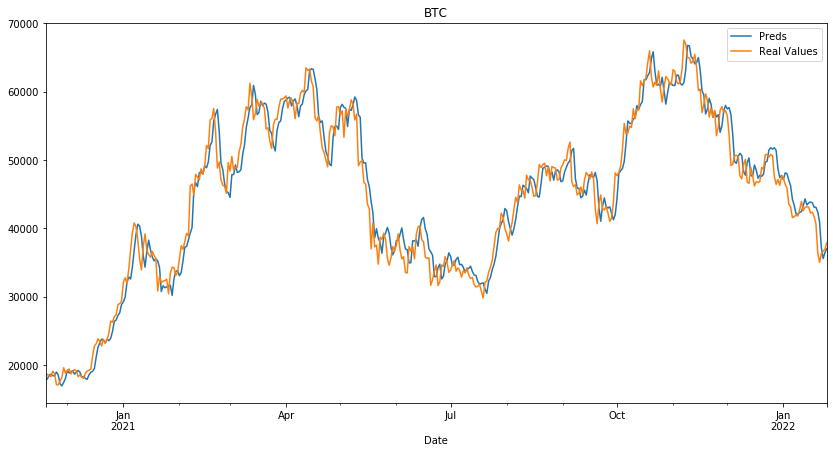

In [77]:
crypto_analyzer.plot_preds_and_real_value(model,X_test,y_test,currency);

In [78]:
next_prediction = crypto_analyzer.get_next_prediction(crypto_analyzer.X_to_predict)
next_prediction

37613.26

In [79]:
currency = "BTC"
crypto_analyzer.arrange_df_for_ann_model(currency,30)
X_train = crypto_analyzer.X_train
X_test = crypto_analyzer.X_test
y_train = crypto_analyzer.y_train
y_test = crypto_analyzer.y_test

Model is ready


In [80]:
path_to_save = "/Users/edenshrian/Desktop/Documents/Eden Shrian/Eden/Projects/Machine learning for Crypto"
model = crypto_analyzer.create_model(X_train,X_test,
                                     y_train,y_test,
                                     currency,
                                     path_to_save)
model = tf.keras.models.load_model(path_to_save+'/'+f"{currency}Model")

Epoch 1/1000
14/14 [==============================] - 1s 52ms/step - loss: 2044.5864 - val_loss: 5989.5063
Epoch 2/1000
14/14 [==============================] - 1s 44ms/step - loss: 743.4722 - val_loss: 4292.5542
Epoch 3/1000
14/14 [==============================] - 1s 44ms/step - loss: 490.9166 - val_loss: 3220.7231
Epoch 4/1000
14/14 [==============================] - 1s 44ms/step - loss: 399.9184 - val_loss: 2911.6562
Epoch 5/1000
14/14 [==============================] - 0s 4ms/step - loss: 376.5422 - val_loss: 3029.6677
Epoch 6/1000
14/14 [==============================] - 1s 44ms/step - loss: 387.9968 - val_loss: 2565.4114
Epoch 7/1000
14/14 [==============================] - 1s 44ms/step - loss: 327.2708 - val_loss: 2416.3821
Epoch 8/1000
14/14 [==============================] - 0s 4ms/step - loss: 310.8614 - val_loss: 2454.1165
Epoch 9/1000
14/14 [==============================] - 0s 5ms/step - loss: 333.4963 - val_loss: 2469.4858
Epoch 10/1000
14/14 [===========================

14/14 [==============================] - 1s 43ms/step - loss: 249.6432 - val_loss: 1930.9139
Epoch 50/1000
14/14 [==============================] - 0s 4ms/step - loss: 257.0658 - val_loss: 2092.0254
Epoch 51/1000
14/14 [==============================] - 0s 3ms/step - loss: 256.1302 - val_loss: 1980.9818
Epoch 52/1000
14/14 [==============================] - 0s 3ms/step - loss: 282.8828 - val_loss: 1950.0981
Epoch 53/1000
14/14 [==============================] - 0s 3ms/step - loss: 249.5615 - val_loss: 1938.1923
Epoch 54/1000
14/14 [==============================] - 1s 43ms/step - loss: 244.3480 - val_loss: 1918.8352
Epoch 55/1000
14/14 [==============================] - 0s 4ms/step - loss: 250.6770 - val_loss: 1957.5641
Epoch 56/1000
14/14 [==============================] - 0s 3ms/step - loss: 246.7403 - val_loss: 1932.6002
Epoch 57/1000
14/14 [==============================] - 0s 3ms/step - loss: 257.3396 - val_loss: 2222.7363
Epoch 58/1000
14/14 [==============================] - 0s 

Epoch 103/1000
14/14 [==============================] - 0s 4ms/step - loss: 234.7835 - val_loss: 1863.6312
Epoch 104/1000
14/14 [==============================] - 0s 3ms/step - loss: 232.0452 - val_loss: 1894.9998
Epoch 105/1000
14/14 [==============================] - 0s 3ms/step - loss: 234.8253 - val_loss: 1945.8241
Epoch 106/1000
14/14 [==============================] - 0s 3ms/step - loss: 257.3621 - val_loss: 2006.5023
Epoch 107/1000
14/14 [==============================] - 0s 3ms/step - loss: 294.8662 - val_loss: 2152.3152
Epoch 108/1000
14/14 [==============================] - 0s 3ms/step - loss: 242.7959 - val_loss: 1868.7202
Epoch 109/1000
14/14 [==============================] - 0s 3ms/step - loss: 228.2245 - val_loss: 2075.9187
Epoch 110/1000
14/14 [==============================] - 0s 3ms/step - loss: 291.7650 - val_loss: 2033.9188
Epoch 111/1000
14/14 [==============================] - 0s 3ms/step - loss: 296.8498 - val_loss: 1906.5490
Epoch 112/1000
14/14 [===============

14/14 [==============================] - 0s 3ms/step - loss: 212.5242 - val_loss: 1893.9329
Epoch 176/1000
14/14 [==============================] - 0s 3ms/step - loss: 213.9881 - val_loss: 1870.2633
Epoch 177/1000
14/14 [==============================] - 0s 3ms/step - loss: 224.3898 - val_loss: 1905.4399
Epoch 178/1000
14/14 [==============================] - 0s 3ms/step - loss: 248.8080 - val_loss: 2050.6343
Epoch 179/1000
14/14 [==============================] - 0s 3ms/step - loss: 229.7257 - val_loss: 1879.9135
Epoch 180/1000
14/14 [==============================] - 0s 3ms/step - loss: 216.3778 - val_loss: 1890.9983
Epoch 181/1000
14/14 [==============================] - 0s 3ms/step - loss: 222.5788 - val_loss: 1891.2919
Epoch 182/1000
14/14 [==============================] - 0s 3ms/step - loss: 220.1479 - val_loss: 1879.0620
Epoch 183/1000
14/14 [==============================] - 0s 3ms/step - loss: 217.7387 - val_loss: 1848.2842
Epoch 184/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 225.5980 - val_loss: 1917.4946
Epoch 252/1000
14/14 [==============================] - 0s 3ms/step - loss: 209.5495 - val_loss: 1877.1488
Epoch 253/1000
14/14 [==============================] - 0s 3ms/step - loss: 209.5497 - val_loss: 1900.1559
Epoch 254/1000
14/14 [==============================] - 0s 3ms/step - loss: 229.3873 - val_loss: 1955.8698
Epoch 255/1000
14/14 [==============================] - 0s 3ms/step - loss: 207.4180 - val_loss: 1939.9705
Epoch 256/1000
14/14 [==============================] - 0s 3ms/step - loss: 219.6004 - val_loss: 1884.9146
Epoch 257/1000
14/14 [==============================] - 0s 3ms/step - loss: 211.0220 - val_loss: 1914.2999
Epoch 258/1000
14/14 [==============================] - 0s 3ms/step - loss: 209.4312 - val_loss: 1892.9393
Epoch 259/1000
14/14 [==============================] - 0s 3ms/step - loss: 217.2268 - val_loss: 1927.4316
Epoch 260/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 211.7570 - val_loss: 1947.7057
Epoch 328/1000
14/14 [==============================] - 0s 3ms/step - loss: 225.1838 - val_loss: 2013.1051
Epoch 329/1000
14/14 [==============================] - 0s 3ms/step - loss: 214.8330 - val_loss: 1917.1869
Epoch 330/1000
14/14 [==============================] - 0s 3ms/step - loss: 206.5327 - val_loss: 1861.1495
Epoch 331/1000
14/14 [==============================] - 0s 3ms/step - loss: 202.3137 - val_loss: 2019.0111
Epoch 332/1000
14/14 [==============================] - 0s 3ms/step - loss: 202.0147 - val_loss: 1964.2568
Epoch 333/1000
14/14 [==============================] - 0s 3ms/step - loss: 208.9687 - val_loss: 1899.9944
Epoch 334/1000
14/14 [==============================] - 0s 3ms/step - loss: 209.3601 - val_loss: 1960.0806
Epoch 335/1000
14/14 [==============================] - 0s 3ms/step - loss: 202.9415 - val_loss: 1886.9214
Epoch 336/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 196.0743 - val_loss: 1897.7225
Epoch 404/1000
14/14 [==============================] - 0s 3ms/step - loss: 196.7262 - val_loss: 1908.4934
Epoch 405/1000
14/14 [==============================] - 0s 3ms/step - loss: 211.3361 - val_loss: 1907.6595
Epoch 406/1000
14/14 [==============================] - 0s 3ms/step - loss: 197.4564 - val_loss: 2118.3721
Epoch 407/1000
14/14 [==============================] - 0s 3ms/step - loss: 232.0950 - val_loss: 2161.1379
Epoch 408/1000
14/14 [==============================] - 0s 3ms/step - loss: 211.8429 - val_loss: 2026.8446
Epoch 409/1000
14/14 [==============================] - 0s 3ms/step - loss: 195.1336 - val_loss: 1922.0907
Epoch 410/1000
14/14 [==============================] - 0s 3ms/step - loss: 189.2363 - val_loss: 2035.4420
Epoch 411/1000
14/14 [==============================] - 0s 3ms/step - loss: 219.6389 - val_loss: 2443.9268
Epoch 412/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 193.6386 - val_loss: 1930.0413
Epoch 480/1000
14/14 [==============================] - 0s 3ms/step - loss: 191.8460 - val_loss: 1934.3652
Epoch 481/1000
14/14 [==============================] - 0s 3ms/step - loss: 187.3905 - val_loss: 1933.3820
Epoch 482/1000
14/14 [==============================] - 0s 3ms/step - loss: 183.9708 - val_loss: 1882.9796
Epoch 483/1000
14/14 [==============================] - 0s 3ms/step - loss: 191.6299 - val_loss: 2057.9773
Epoch 484/1000
14/14 [==============================] - 0s 3ms/step - loss: 195.9070 - val_loss: 1924.4082
Epoch 485/1000
14/14 [==============================] - 0s 3ms/step - loss: 195.1355 - val_loss: 2227.3735
Epoch 486/1000
14/14 [==============================] - 0s 3ms/step - loss: 206.6136 - val_loss: 2107.2297
Epoch 487/1000
14/14 [==============================] - 0s 3ms/step - loss: 201.3297 - val_loss: 1929.8776
Epoch 488/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 197.9598 - val_loss: 1969.8915
Epoch 556/1000
14/14 [==============================] - 0s 5ms/step - loss: 176.7989 - val_loss: 1993.6117
Epoch 557/1000
14/14 [==============================] - 0s 4ms/step - loss: 180.2465 - val_loss: 1937.4841
Epoch 558/1000
14/14 [==============================] - 0s 3ms/step - loss: 206.9626 - val_loss: 2177.9834
Epoch 559/1000
14/14 [==============================] - 0s 5ms/step - loss: 200.2178 - val_loss: 1976.0709
Epoch 560/1000
14/14 [==============================] - 0s 3ms/step - loss: 197.5129 - val_loss: 1936.0760
Epoch 561/1000
14/14 [==============================] - 0s 3ms/step - loss: 189.8519 - val_loss: 2046.7715
Epoch 562/1000
14/14 [==============================] - 0s 3ms/step - loss: 189.0519 - val_loss: 1926.7649
Epoch 563/1000
14/14 [==============================] - 0s 3ms/step - loss: 197.0142 - val_loss: 1936.0721
Epoch 564/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 202.5129 - val_loss: 1992.5243
Epoch 632/1000
14/14 [==============================] - 0s 3ms/step - loss: 195.1656 - val_loss: 2283.1934
Epoch 633/1000
14/14 [==============================] - 0s 3ms/step - loss: 206.1744 - val_loss: 2071.3193
Epoch 634/1000
14/14 [==============================] - 0s 3ms/step - loss: 212.8457 - val_loss: 2393.6475
Epoch 635/1000
14/14 [==============================] - 0s 3ms/step - loss: 216.3711 - val_loss: 2026.7109
Epoch 636/1000
14/14 [==============================] - 0s 3ms/step - loss: 193.7787 - val_loss: 1906.0996
Epoch 637/1000
14/14 [==============================] - 0s 3ms/step - loss: 173.3428 - val_loss: 2045.6982
Epoch 638/1000
14/14 [==============================] - 0s 5ms/step - loss: 180.6197 - val_loss: 1959.5033
Epoch 639/1000
14/14 [==============================] - 0s 4ms/step - loss: 176.5261 - val_loss: 1904.1667
Epoch 640/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 191.9040 - val_loss: 1942.7312
Epoch 708/1000
14/14 [==============================] - 0s 3ms/step - loss: 176.6959 - val_loss: 1942.5492
Epoch 709/1000
14/14 [==============================] - 0s 3ms/step - loss: 172.6972 - val_loss: 2051.8699
Epoch 710/1000
14/14 [==============================] - 0s 3ms/step - loss: 189.5285 - val_loss: 2199.7517
Epoch 711/1000
14/14 [==============================] - 0s 3ms/step - loss: 189.9492 - val_loss: 1984.8329
Epoch 712/1000
14/14 [==============================] - 0s 3ms/step - loss: 168.5681 - val_loss: 2052.1448
Epoch 713/1000
14/14 [==============================] - 0s 3ms/step - loss: 184.5108 - val_loss: 2048.5400
Epoch 714/1000
14/14 [==============================] - 0s 3ms/step - loss: 173.4238 - val_loss: 1995.1340
Epoch 715/1000
14/14 [==============================] - 0s 3ms/step - loss: 171.6518 - val_loss: 2047.6908
Epoch 716/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 173.8306 - val_loss: 2044.7393
Epoch 784/1000
14/14 [==============================] - 0s 3ms/step - loss: 209.6545 - val_loss: 2200.0884
Epoch 785/1000
14/14 [==============================] - 0s 3ms/step - loss: 202.7669 - val_loss: 2188.3164
Epoch 786/1000
14/14 [==============================] - 0s 3ms/step - loss: 183.9846 - val_loss: 1981.4052
Epoch 787/1000
14/14 [==============================] - 0s 3ms/step - loss: 166.6855 - val_loss: 2014.1611
Epoch 788/1000
14/14 [==============================] - 0s 3ms/step - loss: 167.1537 - val_loss: 1933.9895
Epoch 789/1000
14/14 [==============================] - 0s 3ms/step - loss: 172.0745 - val_loss: 1952.1147
Epoch 790/1000
14/14 [==============================] - 0s 3ms/step - loss: 167.5082 - val_loss: 1963.4056
Epoch 791/1000
14/14 [==============================] - 0s 3ms/step - loss: 166.4150 - val_loss: 1974.3748
Epoch 792/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 163.9027 - val_loss: 2020.6848
Epoch 860/1000
14/14 [==============================] - 0s 3ms/step - loss: 156.6121 - val_loss: 2043.4365
Epoch 861/1000
14/14 [==============================] - 0s 3ms/step - loss: 168.6327 - val_loss: 2069.5576
Epoch 862/1000
14/14 [==============================] - 0s 3ms/step - loss: 161.5197 - val_loss: 2085.8750
Epoch 863/1000
14/14 [==============================] - 0s 3ms/step - loss: 164.1703 - val_loss: 1999.3861
Epoch 864/1000
14/14 [==============================] - 0s 3ms/step - loss: 168.6103 - val_loss: 2031.6749
Epoch 865/1000
14/14 [==============================] - 0s 3ms/step - loss: 174.2168 - val_loss: 2015.3491
Epoch 866/1000
14/14 [==============================] - 0s 3ms/step - loss: 168.1807 - val_loss: 2056.2124
Epoch 867/1000
14/14 [==============================] - 0s 3ms/step - loss: 160.3183 - val_loss: 1988.1635
Epoch 868/1000
14/14 [==============================

14/14 [==============================] - 0s 3ms/step - loss: 153.1749 - val_loss: 2091.5515
Epoch 936/1000
14/14 [==============================] - 0s 3ms/step - loss: 156.1027 - val_loss: 2119.8889
Epoch 937/1000
14/14 [==============================] - 0s 3ms/step - loss: 177.3305 - val_loss: 2078.1870
Epoch 938/1000
14/14 [==============================] - 0s 3ms/step - loss: 167.3100 - val_loss: 2028.9056
Epoch 939/1000
14/14 [==============================] - 0s 3ms/step - loss: 162.8396 - val_loss: 2145.4814
Epoch 940/1000
14/14 [==============================] - 0s 3ms/step - loss: 168.9946 - val_loss: 2062.2717
Epoch 941/1000
14/14 [==============================] - 0s 3ms/step - loss: 172.9570 - val_loss: 2015.2080
Epoch 942/1000
14/14 [==============================] - 0s 3ms/step - loss: 157.3284 - val_loss: 2126.3274
Epoch 943/1000
14/14 [==============================] - 0s 3ms/step - loss: 173.2491 - val_loss: 1982.6042
Epoch 944/1000
14/14 [==============================

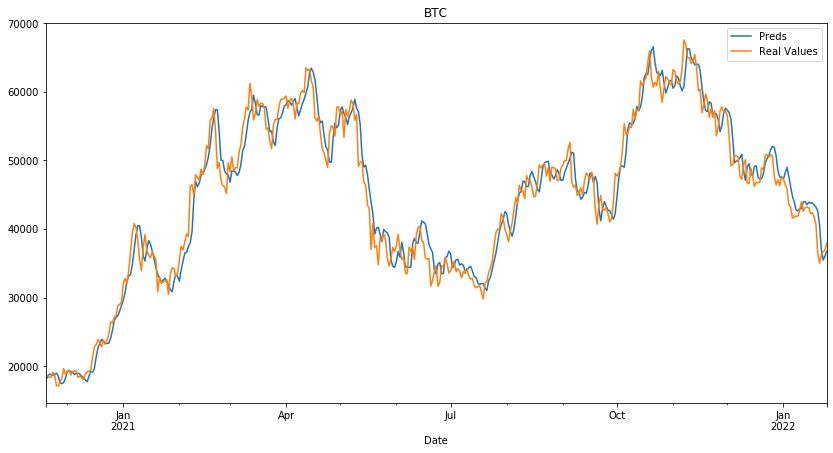

In [81]:
crypto_analyzer.plot_preds_and_real_value(model,X_test,y_test,currency);

In [82]:
next_prediction = crypto_analyzer.get_next_prediction(crypto_analyzer.X_to_predict)
next_prediction

37982.332

## ETH

In [83]:
currency = "ETH"
crypto_analyzer.arrange_df_for_ann_model(currency,7)
X_train = crypto_analyzer.X_train
X_test = crypto_analyzer.X_test
y_train = crypto_analyzer.y_train
y_test = crypto_analyzer.y_test

Model is ready


In [84]:
path_to_save = "/Users/edenshrian/Desktop/Documents/Eden Shrian/Eden/Projects/Machine learning for Crypto"
model = crypto_analyzer.create_model(X_train,X_test,
                                     y_train,y_test,
                                     currency,
                                     path_to_save)
model = tf.keras.models.load_model(path_to_save+'/'+f"{currency}Model")

Epoch 1/1000
9/9 [==============================] - 1s 81ms/step - loss: 180.9575 - val_loss: 973.7526
Epoch 2/1000
9/9 [==============================] - 1s 69ms/step - loss: 69.8634 - val_loss: 371.0986
Epoch 3/1000
9/9 [==============================] - 1s 123ms/step - loss: 41.1138 - val_loss: 346.5688
Epoch 4/1000
9/9 [==============================] - 1s 69ms/step - loss: 38.3655 - val_loss: 271.8024
Epoch 5/1000
9/9 [==============================] - 1s 70ms/step - loss: 35.5094 - val_loss: 244.4298
Epoch 6/1000
9/9 [==============================] - 1s 69ms/step - loss: 32.6041 - val_loss: 218.2985
Epoch 7/1000
9/9 [==============================] - 1s 70ms/step - loss: 29.5862 - val_loss: 202.5164
Epoch 8/1000
9/9 [==============================] - 0s 5ms/step - loss: 27.5085 - val_loss: 214.2805
Epoch 9/1000
9/9 [==============================] - 0s 8ms/step - loss: 28.0131 - val_loss: 212.1765
Epoch 10/1000
9/9 [==============================] - 1s 72ms/step - loss: 28.0053 

Epoch 50/1000
9/9 [==============================] - 0s 5ms/step - loss: 22.4744 - val_loss: 168.7482
Epoch 51/1000
9/9 [==============================] - 0s 5ms/step - loss: 24.0023 - val_loss: 183.9268
Epoch 52/1000
9/9 [==============================] - 0s 4ms/step - loss: 23.7805 - val_loss: 196.1505
Epoch 53/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.5805 - val_loss: 170.3114
Epoch 54/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.2169 - val_loss: 181.2450
Epoch 55/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.2677 - val_loss: 212.7971
Epoch 56/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.1346 - val_loss: 194.5770
Epoch 57/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.8915 - val_loss: 166.9684
Epoch 58/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.0332 - val_loss: 187.0766
Epoch 59/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.8188 -

9/9 [==============================] - 0s 4ms/step - loss: 22.7611 - val_loss: 169.6843
Epoch 121/1000
9/9 [==============================] - 0s 4ms/step - loss: 23.6930 - val_loss: 196.9478
Epoch 122/1000
9/9 [==============================] - 0s 4ms/step - loss: 25.0296 - val_loss: 171.4642
Epoch 123/1000
9/9 [==============================] - 0s 4ms/step - loss: 27.4585 - val_loss: 201.9071
Epoch 124/1000
9/9 [==============================] - 0s 4ms/step - loss: 24.3323 - val_loss: 200.4476
Epoch 125/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.5942 - val_loss: 171.2127
Epoch 126/1000
9/9 [==============================] - 0s 4ms/step - loss: 24.4925 - val_loss: 182.9983
Epoch 127/1000
9/9 [==============================] - 0s 4ms/step - loss: 23.7820 - val_loss: 168.8455
Epoch 128/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.1398 - val_loss: 180.0861
Epoch 129/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.6137 - val_

9/9 [==============================] - 0s 4ms/step - loss: 23.3077 - val_loss: 170.2348
Epoch 196/1000
9/9 [==============================] - 0s 5ms/step - loss: 22.6498 - val_loss: 176.7233
Epoch 197/1000
9/9 [==============================] - 0s 4ms/step - loss: 23.5729 - val_loss: 194.8022
Epoch 198/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.7445 - val_loss: 223.1195
Epoch 199/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.7179 - val_loss: 169.2606
Epoch 200/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.1653 - val_loss: 174.7760
Epoch 201/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.8692 - val_loss: 169.0315
Epoch 202/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.7630 - val_loss: 182.0049
Epoch 203/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.2423 - val_loss: 204.1907
Epoch 204/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.8112 - val_

9/9 [==============================] - 0s 5ms/step - loss: 21.1632 - val_loss: 169.8232
Epoch 275/1000
9/9 [==============================] - 0s 5ms/step - loss: 21.1069 - val_loss: 168.9176
Epoch 276/1000
9/9 [==============================] - 0s 5ms/step - loss: 23.0675 - val_loss: 168.6935
Epoch 277/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.2879 - val_loss: 212.1151
Epoch 278/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.2005 - val_loss: 169.6202
Epoch 279/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.4985 - val_loss: 193.7710
Epoch 280/1000
9/9 [==============================] - 0s 5ms/step - loss: 21.0008 - val_loss: 166.4468
Epoch 281/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.5426 - val_loss: 169.9335
Epoch 282/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.3735 - val_loss: 167.3391
Epoch 283/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.2439 - val_

9/9 [==============================] - 0s 4ms/step - loss: 19.9901 - val_loss: 169.6125
Epoch 354/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.5355 - val_loss: 241.3539
Epoch 355/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.8805 - val_loss: 167.2208
Epoch 356/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.7867 - val_loss: 170.6463
Epoch 357/1000
9/9 [==============================] - 0s 7ms/step - loss: 21.9460 - val_loss: 171.1840
Epoch 358/1000
9/9 [==============================] - 0s 5ms/step - loss: 21.5880 - val_loss: 184.4959
Epoch 359/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.5193 - val_loss: 223.8851
Epoch 360/1000
9/9 [==============================] - 0s 5ms/step - loss: 21.6463 - val_loss: 199.0606
Epoch 361/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.5761 - val_loss: 186.0208
Epoch 362/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.7755 - val_

9/9 [==============================] - 0s 4ms/step - loss: 20.6990 - val_loss: 228.6528
Epoch 433/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.8938 - val_loss: 238.7703
Epoch 434/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.0054 - val_loss: 187.4930
Epoch 435/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.0934 - val_loss: 181.9672
Epoch 436/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.5118 - val_loss: 266.2820
Epoch 437/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.8498 - val_loss: 226.9325
Epoch 438/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.6235 - val_loss: 171.7198
Epoch 439/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.5277 - val_loss: 168.0377
Epoch 440/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.4844 - val_loss: 182.6092
Epoch 441/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.4503 - val_

9/9 [==============================] - 0s 4ms/step - loss: 19.6952 - val_loss: 180.1640
Epoch 512/1000
9/9 [==============================] - 0s 5ms/step - loss: 19.0354 - val_loss: 172.9492
Epoch 513/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.0151 - val_loss: 207.0616
Epoch 514/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.6436 - val_loss: 186.9444
Epoch 515/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.0516 - val_loss: 179.6414
Epoch 516/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.7153 - val_loss: 176.7480
Epoch 517/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.3067 - val_loss: 184.9653
Epoch 518/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.0883 - val_loss: 172.2119
Epoch 519/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.1742 - val_loss: 179.2471
Epoch 520/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.6479 - val_

9/9 [==============================] - 0s 5ms/step - loss: 20.4826 - val_loss: 174.9989
Epoch 591/1000
9/9 [==============================] - 0s 5ms/step - loss: 18.2962 - val_loss: 181.0121
Epoch 592/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.9911 - val_loss: 217.0193
Epoch 593/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.2660 - val_loss: 194.5503
Epoch 594/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.1974 - val_loss: 178.3307
Epoch 595/1000
9/9 [==============================] - 0s 5ms/step - loss: 19.9669 - val_loss: 209.3264
Epoch 596/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.1422 - val_loss: 187.1869
Epoch 597/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.5177 - val_loss: 171.7943
Epoch 598/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.6612 - val_loss: 225.4014
Epoch 599/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.6770 - val_

9/9 [==============================] - 0s 4ms/step - loss: 19.3271 - val_loss: 185.8049
Epoch 670/1000
9/9 [==============================] - 0s 5ms/step - loss: 19.6573 - val_loss: 174.3828
Epoch 671/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.8067 - val_loss: 184.7073
Epoch 672/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.6104 - val_loss: 195.8688
Epoch 673/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.2706 - val_loss: 191.2033
Epoch 674/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.3774 - val_loss: 175.0934
Epoch 675/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.1228 - val_loss: 178.1989
Epoch 676/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.1304 - val_loss: 191.1779
Epoch 677/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.4172 - val_loss: 180.7798
Epoch 678/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.7787 - val_

9/9 [==============================] - 0s 4ms/step - loss: 18.6755 - val_loss: 212.7215
Epoch 749/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.9866 - val_loss: 189.8547
Epoch 750/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.6353 - val_loss: 182.7960
Epoch 751/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.4145 - val_loss: 174.1781
Epoch 752/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.1508 - val_loss: 208.2539
Epoch 753/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.8166 - val_loss: 255.0417
Epoch 754/1000
9/9 [==============================] - 0s 4ms/step - loss: 23.0068 - val_loss: 265.2268
Epoch 755/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.6248 - val_loss: 248.6346
Epoch 756/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.7302 - val_loss: 193.4082
Epoch 757/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.4040 - val_

9/9 [==============================] - 0s 4ms/step - loss: 18.1374 - val_loss: 190.5966
Epoch 828/1000
9/9 [==============================] - 0s 5ms/step - loss: 18.5862 - val_loss: 185.0836
Epoch 829/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.0142 - val_loss: 220.7303
Epoch 830/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.8890 - val_loss: 189.1308
Epoch 831/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.0548 - val_loss: 191.3468
Epoch 832/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.1308 - val_loss: 200.0176
Epoch 833/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.4387 - val_loss: 187.6327
Epoch 834/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.5983 - val_loss: 179.8619
Epoch 835/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.0111 - val_loss: 206.8778
Epoch 836/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.9355 - val_

9/9 [==============================] - 0s 4ms/step - loss: 16.9939 - val_loss: 186.7476
Epoch 907/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.2333 - val_loss: 188.6396
Epoch 908/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.3458 - val_loss: 178.6124
Epoch 909/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.7370 - val_loss: 205.3741
Epoch 910/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.9568 - val_loss: 199.9622
Epoch 911/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.4325 - val_loss: 187.8753
Epoch 912/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.5978 - val_loss: 213.6917
Epoch 913/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.5962 - val_loss: 209.3555
Epoch 914/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.4224 - val_loss: 203.0400
Epoch 915/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.1219 - val_

9/9 [==============================] - 0s 5ms/step - loss: 15.9477 - val_loss: 185.6992
Epoch 986/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.3984 - val_loss: 219.1362
Epoch 987/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.3488 - val_loss: 221.9404
Epoch 988/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.6440 - val_loss: 182.4799
Epoch 989/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.1354 - val_loss: 191.5207
Epoch 990/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.8238 - val_loss: 207.7462
Epoch 991/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.1621 - val_loss: 199.6847
Epoch 992/1000
9/9 [==============================] - 0s 7ms/step - loss: 16.2315 - val_loss: 183.4550
Epoch 993/1000
9/9 [==============================] - 0s 8ms/step - loss: 16.0130 - val_loss: 186.7292
Epoch 994/1000
9/9 [==============================] - 0s 5ms/step - loss: 18.8277 - val_

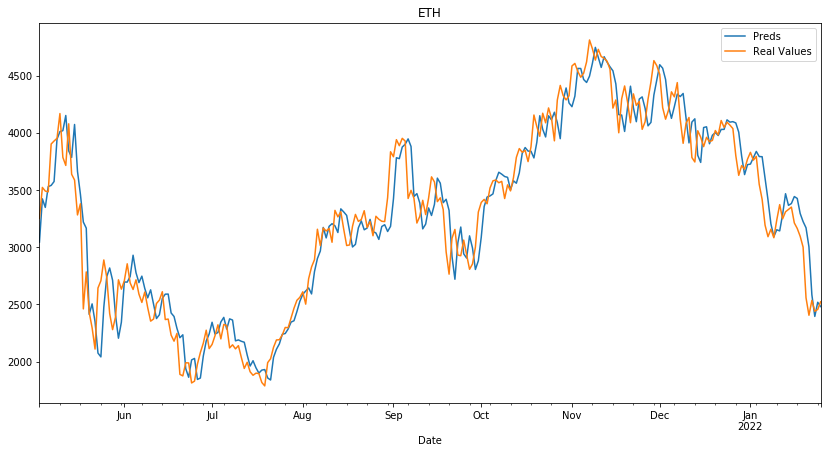

In [85]:
crypto_analyzer.plot_preds_and_real_value(model,X_test,y_test,currency);

In [86]:
next_prediction = crypto_analyzer.get_next_prediction(crypto_analyzer.X_to_predict)
next_prediction

2485.971

In [87]:
currency = "ETH"
crypto_analyzer.arrange_df_for_ann_model(currency,30)
X_train = crypto_analyzer.X_train
X_test = crypto_analyzer.X_test
y_train = crypto_analyzer.y_train
y_test = crypto_analyzer.y_test

Model is ready


In [88]:
path_to_save = "/Users/edenshrian/Desktop/Documents/Eden Shrian/Eden/Projects/Machine learning for Crypto"
model = crypto_analyzer.create_model(X_train,X_test,
                                     y_train,y_test,
                                     currency,
                                     path_to_save)
model = tf.keras.models.load_model(path_to_save+'/'+f"{currency}Model")

Epoch 1/1000
9/9 [==============================] - 1s 81ms/step - loss: 189.4095 - val_loss: 532.3496
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 64.9463 - val_loss: 624.9033
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 54.1953 - val_loss: 593.5225
Epoch 4/1000
9/9 [==============================] - 1s 68ms/step - loss: 53.4697 - val_loss: 380.4922
Epoch 5/1000
9/9 [==============================] - 1s 70ms/step - loss: 37.3898 - val_loss: 330.9499
Epoch 6/1000
9/9 [==============================] - 1s 72ms/step - loss: 36.2365 - val_loss: 298.4877
Epoch 7/1000
9/9 [==============================] - 1s 69ms/step - loss: 33.1011 - val_loss: 236.3390
Epoch 8/1000
9/9 [==============================] - 0s 5ms/step - loss: 32.5422 - val_loss: 260.8435
Epoch 9/1000
9/9 [==============================] - 1s 124ms/step - loss: 30.7052 - val_loss: 223.6729
Epoch 10/1000
9/9 [==============================] - 1s 69ms/step - loss: 29.5572 -

9/9 [==============================] - 0s 5ms/step - loss: 26.6878 - val_loss: 226.9828
Epoch 48/1000
9/9 [==============================] - 0s 4ms/step - loss: 27.7848 - val_loss: 180.7388
Epoch 49/1000
9/9 [==============================] - 0s 4ms/step - loss: 26.7481 - val_loss: 182.1012
Epoch 50/1000
9/9 [==============================] - 0s 4ms/step - loss: 26.0899 - val_loss: 181.9783
Epoch 51/1000
9/9 [==============================] - 0s 4ms/step - loss: 25.4025 - val_loss: 201.6450
Epoch 52/1000
9/9 [==============================] - 0s 4ms/step - loss: 25.1102 - val_loss: 249.1978
Epoch 53/1000
9/9 [==============================] - 0s 4ms/step - loss: 26.3645 - val_loss: 189.4192
Epoch 54/1000
9/9 [==============================] - 0s 4ms/step - loss: 23.7888 - val_loss: 206.9445
Epoch 55/1000
9/9 [==============================] - 0s 4ms/step - loss: 23.1118 - val_loss: 189.5339
Epoch 56/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.8456 - val_loss: 182

9/9 [==============================] - 0s 5ms/step - loss: 21.8973 - val_loss: 175.2833
Epoch 120/1000
9/9 [==============================] - 0s 7ms/step - loss: 20.2628 - val_loss: 184.0286
Epoch 121/1000
9/9 [==============================] - 0s 5ms/step - loss: 22.6937 - val_loss: 174.8247
Epoch 122/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.1127 - val_loss: 180.1359
Epoch 123/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.4148 - val_loss: 178.5917
Epoch 124/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.5160 - val_loss: 205.2819
Epoch 125/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.2512 - val_loss: 195.3120
Epoch 126/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.2973 - val_loss: 232.6657
Epoch 127/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.3297 - val_loss: 176.0692
Epoch 128/1000
9/9 [==============================] - 0s 4ms/step - loss: 24.0288 - val_

9/9 [==============================] - 1s 67ms/step - loss: 19.3463 - val_loss: 167.6005
Epoch 194/1000
9/9 [==============================] - 0s 5ms/step - loss: 20.0649 - val_loss: 196.3376
Epoch 195/1000
9/9 [==============================] - 0s 5ms/step - loss: 18.9675 - val_loss: 171.1910
Epoch 196/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.1255 - val_loss: 191.5338
Epoch 197/1000
9/9 [==============================] - 0s 5ms/step - loss: 20.8001 - val_loss: 170.6768
Epoch 198/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.7305 - val_loss: 198.6113
Epoch 199/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.9161 - val_loss: 187.0411
Epoch 200/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.1404 - val_loss: 176.3528
Epoch 201/1000
9/9 [==============================] - 0s 5ms/step - loss: 22.1074 - val_loss: 182.9146
Epoch 202/1000
9/9 [==============================] - 0s 5ms/step - loss: 18.4712 - val

9/9 [==============================] - 0s 4ms/step - loss: 17.9553 - val_loss: 168.9056
Epoch 271/1000
9/9 [==============================] - 0s 4ms/step - loss: 23.7906 - val_loss: 187.5864
Epoch 272/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.1124 - val_loss: 188.1815
Epoch 273/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.6971 - val_loss: 210.8793
Epoch 274/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.7631 - val_loss: 173.4005
Epoch 275/1000
9/9 [==============================] - 0s 7ms/step - loss: 18.3862 - val_loss: 172.0138
Epoch 276/1000
9/9 [==============================] - 0s 5ms/step - loss: 17.3059 - val_loss: 177.9272
Epoch 277/1000
9/9 [==============================] - 0s 5ms/step - loss: 17.5559 - val_loss: 180.3687
Epoch 278/1000
9/9 [==============================] - 0s 5ms/step - loss: 18.2849 - val_loss: 175.0386
Epoch 279/1000
9/9 [==============================] - 0s 5ms/step - loss: 17.8467 - val_

9/9 [==============================] - 0s 5ms/step - loss: 22.4258 - val_loss: 177.5190
Epoch 346/1000
9/9 [==============================] - 0s 5ms/step - loss: 21.3456 - val_loss: 235.7545
Epoch 347/1000
9/9 [==============================] - 0s 4ms/step - loss: 22.6570 - val_loss: 195.6066
Epoch 348/1000
9/9 [==============================] - 0s 4ms/step - loss: 21.3912 - val_loss: 170.5441
Epoch 349/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.4124 - val_loss: 187.4551
Epoch 350/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.2965 - val_loss: 174.7141
Epoch 351/1000
9/9 [==============================] - 0s 5ms/step - loss: 15.8575 - val_loss: 173.2916
Epoch 352/1000
9/9 [==============================] - 0s 5ms/step - loss: 21.1910 - val_loss: 219.8629
Epoch 353/1000
9/9 [==============================] - 0s 5ms/step - loss: 24.6185 - val_loss: 251.8180
Epoch 354/1000
9/9 [==============================] - 0s 4ms/step - loss: 20.5396 - val_

9/9 [==============================] - 0s 4ms/step - loss: 17.7143 - val_loss: 200.1044
Epoch 423/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.8671 - val_loss: 176.4598
Epoch 424/1000
9/9 [==============================] - 0s 4ms/step - loss: 15.5208 - val_loss: 182.5648
Epoch 425/1000
9/9 [==============================] - 0s 4ms/step - loss: 15.2086 - val_loss: 168.3389
Epoch 426/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.4375 - val_loss: 178.7378
Epoch 427/1000
9/9 [==============================] - 0s 4ms/step - loss: 15.9398 - val_loss: 191.9448
Epoch 428/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.0354 - val_loss: 174.7685
Epoch 429/1000
9/9 [==============================] - 0s 4ms/step - loss: 19.5229 - val_loss: 172.4516
Epoch 430/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.6577 - val_loss: 225.6654
Epoch 431/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.5409 - val_

9/9 [==============================] - 0s 4ms/step - loss: 14.6764 - val_loss: 176.7192
Epoch 502/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.0829 - val_loss: 211.1869
Epoch 503/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.3729 - val_loss: 171.3784
Epoch 504/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.9625 - val_loss: 179.1099
Epoch 505/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.0670 - val_loss: 178.4576
Epoch 506/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.5309 - val_loss: 177.8382
Epoch 507/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.7965 - val_loss: 223.5984
Epoch 508/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.4954 - val_loss: 175.2518
Epoch 509/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.5119 - val_loss: 185.1463
Epoch 510/1000
9/9 [==============================] - 0s 4ms/step - loss: 15.4364 - val_

9/9 [==============================] - 0s 4ms/step - loss: 14.9493 - val_loss: 202.9279
Epoch 581/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.6382 - val_loss: 180.2443
Epoch 582/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.6374 - val_loss: 178.7418
Epoch 583/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.7461 - val_loss: 180.1414
Epoch 584/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.1907 - val_loss: 178.7052
Epoch 585/1000
9/9 [==============================] - 0s 4ms/step - loss: 15.2551 - val_loss: 185.0853
Epoch 586/1000
9/9 [==============================] - 0s 4ms/step - loss: 15.4478 - val_loss: 175.1466
Epoch 587/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.8093 - val_loss: 177.2238
Epoch 588/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.5268 - val_loss: 198.5352
Epoch 589/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.3268 - val_

9/9 [==============================] - 0s 4ms/step - loss: 17.1725 - val_loss: 171.2611
Epoch 660/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.6373 - val_loss: 191.2082
Epoch 661/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.5370 - val_loss: 179.7066
Epoch 662/1000
9/9 [==============================] - 0s 4ms/step - loss: 17.6188 - val_loss: 194.1150
Epoch 663/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.4742 - val_loss: 186.7359
Epoch 664/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.2653 - val_loss: 186.5396
Epoch 665/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.1482 - val_loss: 198.3743
Epoch 666/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.3278 - val_loss: 183.4347
Epoch 667/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.7632 - val_loss: 182.6487
Epoch 668/1000
9/9 [==============================] - 0s 4ms/step - loss: 18.1467 - val_

9/9 [==============================] - 0s 4ms/step - loss: 15.1349 - val_loss: 186.3758
Epoch 739/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.2029 - val_loss: 178.8424
Epoch 740/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.1705 - val_loss: 181.7285
Epoch 741/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.8763 - val_loss: 184.6563
Epoch 742/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.7086 - val_loss: 185.6391
Epoch 743/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.9378 - val_loss: 183.7531
Epoch 744/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.8283 - val_loss: 175.0741
Epoch 745/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.4800 - val_loss: 200.8836
Epoch 746/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.4354 - val_loss: 181.5711
Epoch 747/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.3407 - val_

9/9 [==============================] - 0s 4ms/step - loss: 12.6120 - val_loss: 181.3939
Epoch 818/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.0480 - val_loss: 181.1062
Epoch 819/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.2776 - val_loss: 174.4079
Epoch 820/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.9760 - val_loss: 182.3510
Epoch 821/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.5015 - val_loss: 178.8353
Epoch 822/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.9048 - val_loss: 199.0462
Epoch 823/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.1350 - val_loss: 183.5883
Epoch 824/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.4799 - val_loss: 181.4099
Epoch 825/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.9011 - val_loss: 183.8211
Epoch 826/1000
9/9 [==============================] - 0s 4ms/step - loss: 16.4918 - val_

9/9 [==============================] - 0s 5ms/step - loss: 14.2702 - val_loss: 186.2400
Epoch 897/1000
9/9 [==============================] - 0s 5ms/step - loss: 15.1128 - val_loss: 187.2905
Epoch 898/1000
9/9 [==============================] - 0s 5ms/step - loss: 14.7194 - val_loss: 185.6199
Epoch 899/1000
9/9 [==============================] - 0s 5ms/step - loss: 14.0921 - val_loss: 173.3758
Epoch 900/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.1457 - val_loss: 183.0616
Epoch 901/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.3616 - val_loss: 201.3279
Epoch 902/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.8281 - val_loss: 191.4217
Epoch 903/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.6514 - val_loss: 187.9757
Epoch 904/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.2710 - val_loss: 186.5862
Epoch 905/1000
9/9 [==============================] - 0s 4ms/step - loss: 11.6096 - val_

9/9 [==============================] - 0s 4ms/step - loss: 10.8781 - val_loss: 191.4120
Epoch 976/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.9764 - val_loss: 189.6910
Epoch 977/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.5124 - val_loss: 192.7520
Epoch 978/1000
9/9 [==============================] - 0s 4ms/step - loss: 13.6381 - val_loss: 183.4197
Epoch 979/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.8192 - val_loss: 184.6744
Epoch 980/1000
9/9 [==============================] - 0s 4ms/step - loss: 12.0955 - val_loss: 181.8902
Epoch 981/1000
9/9 [==============================] - 0s 4ms/step - loss: 11.6211 - val_loss: 187.3813
Epoch 982/1000
9/9 [==============================] - 0s 4ms/step - loss: 11.8290 - val_loss: 187.9771
Epoch 983/1000
9/9 [==============================] - 0s 4ms/step - loss: 14.3466 - val_loss: 209.9499
Epoch 984/1000
9/9 [==============================] - 0s 4ms/step - loss: 15.8176 - val_

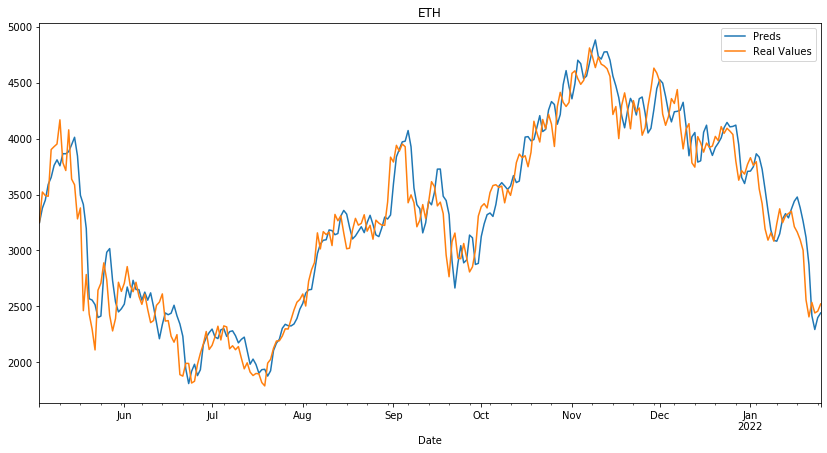

In [89]:
crypto_analyzer.plot_preds_and_real_value(model,X_test,y_test,currency);

In [90]:
next_prediction = crypto_analyzer.get_next_prediction(crypto_analyzer.X_to_predict)
next_prediction

2489.704

## BNB

In [91]:
currency = "BNB"
crypto_analyzer.arrange_df_for_ann_model(currency,7)
X_train = crypto_analyzer.X_train
X_test = crypto_analyzer.X_test
y_train = crypto_analyzer.y_train
y_test = crypto_analyzer.y_test

Model is ready


In [92]:
path_to_save = "/Users/edenshrian/Desktop/Documents/Eden Shrian/Eden/Projects/Machine learning for Crypto"
model = crypto_analyzer.create_model(X_train,X_test,
                                     y_train,y_test,
                                     currency,
                                     path_to_save)
model = tf.keras.models.load_model(path_to_save+'/'+f"{currency}Model")

Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 19.5659 - val_loss: nan
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 8.3486 - val_loss: nan
Epoch 3/1000
9/9 [==============================] - 0s 8ms/step - loss: 5.5597 - val_loss: nan
Epoch 4/1000
9/9 [==============================] - 0s 8ms/step - loss: 4.9486 - val_loss: nan
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 4.6804 - val_loss: nan
Epoch 6/1000
9/9 [==============================] - 0s 8ms/step - loss: 4.1070 - val_loss: nan
Epoch 7/1000
9/9 [==============================] - 0s 8ms/step - loss: 3.6470 - val_loss: nan
Epoch 8/1000
9/9 [==============================] - 0s 5ms/step - loss: 3.6006 - val_loss: nan
Epoch 9/1000
9/9 [==============================] - 0s 5ms/step - loss: 3.4900 - val_loss: nan
Epoch 10/1000
9/9 [==============================] - 0s 8ms/step - loss: 3.2841 - val_loss: nan
Epoch 11/1000
9/9 [============================

9/9 [==============================] - 0s 5ms/step - loss: 2.7247 - val_loss: nan
Epoch 87/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.6153 - val_loss: nan
Epoch 88/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.5698 - val_loss: nan
Epoch 89/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.7432 - val_loss: nan
Epoch 90/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.8598 - val_loss: nan
Epoch 91/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.6280 - val_loss: nan
Epoch 92/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.6080 - val_loss: nan
Epoch 93/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.5493 - val_loss: nan
Epoch 94/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.5887 - val_loss: nan
Epoch 95/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.9678 - val_loss: nan
Epoch 96/1000
9/9 [==============================] - 0

9/9 [==============================] - 0s 5ms/step - loss: 2.2616 - val_loss: nan
Epoch 171/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.3581 - val_loss: nan
Epoch 172/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.2994 - val_loss: nan
Epoch 173/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.2692 - val_loss: nan
Epoch 174/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.3932 - val_loss: nan
Epoch 175/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.6289 - val_loss: nan
Epoch 176/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.6724 - val_loss: nan
Epoch 177/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.3837 - val_loss: nan
Epoch 178/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.3364 - val_loss: nan
Epoch 179/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.8766 - val_loss: nan
Epoch 180/1000
9/9 [=========================

9/9 [==============================] - 0s 7ms/step - loss: 2.8060 - val_loss: nan
Epoch 255/1000
9/9 [==============================] - 0s 7ms/step - loss: 2.7212 - val_loss: nan
Epoch 256/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.0365 - val_loss: nan
Epoch 257/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.2065 - val_loss: nan
Epoch 258/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.0377 - val_loss: nan
Epoch 259/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.2226 - val_loss: nan
Epoch 260/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.3157 - val_loss: nan
Epoch 261/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.1821 - val_loss: nan
Epoch 262/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.0786 - val_loss: nan
Epoch 263/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.0905 - val_loss: nan
Epoch 264/1000
9/9 [=========================

9/9 [==============================] - 0s 5ms/step - loss: 2.1234 - val_loss: nan
Epoch 339/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.8890 - val_loss: nan
Epoch 340/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.9641 - val_loss: nan
Epoch 341/1000
9/9 [==============================] - 0s 5ms/step - loss: 2.0130 - val_loss: nan
Epoch 342/1000
9/9 [==============================] - 0s 4ms/step - loss: 2.0336 - val_loss: nan
Epoch 343/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.9545 - val_loss: nan
Epoch 344/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.8677 - val_loss: nan
Epoch 345/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.9423 - val_loss: nan
Epoch 346/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.9995 - val_loss: nan
Epoch 347/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.8494 - val_loss: nan
Epoch 348/1000
9/9 [=========================

9/9 [==============================] - 0s 4ms/step - loss: 1.7172 - val_loss: nan
Epoch 423/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.7187 - val_loss: nan
Epoch 424/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.9517 - val_loss: nan
Epoch 425/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.8855 - val_loss: nan
Epoch 426/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.7646 - val_loss: nan
Epoch 427/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.7986 - val_loss: nan
Epoch 428/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.9836 - val_loss: nan
Epoch 429/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.9905 - val_loss: nan
Epoch 430/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.7502 - val_loss: nan
Epoch 431/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.7342 - val_loss: nan
Epoch 432/1000
9/9 [=========================

9/9 [==============================] - 0s 5ms/step - loss: 1.7515 - val_loss: nan
Epoch 507/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.5519 - val_loss: nan
Epoch 508/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.7075 - val_loss: nan
Epoch 509/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.7714 - val_loss: nan
Epoch 510/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.8003 - val_loss: nan
Epoch 511/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.7062 - val_loss: nan
Epoch 512/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.6119 - val_loss: nan
Epoch 513/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.6830 - val_loss: nan
Epoch 514/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.6433 - val_loss: nan
Epoch 515/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.5152 - val_loss: nan
Epoch 516/1000
9/9 [=========================

9/9 [==============================] - 0s 6ms/step - loss: 1.6005 - val_loss: nan
Epoch 591/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.4718 - val_loss: nan
Epoch 592/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.7913 - val_loss: nan
Epoch 593/1000
9/9 [==============================] - 0s 8ms/step - loss: 1.7308 - val_loss: nan
Epoch 594/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.5850 - val_loss: nan
Epoch 595/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.5485 - val_loss: nan
Epoch 596/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.5077 - val_loss: nan
Epoch 597/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.5019 - val_loss: nan
Epoch 598/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.4765 - val_loss: nan
Epoch 599/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.6582 - val_loss: nan
Epoch 600/1000
9/9 [=========================

9/9 [==============================] - 0s 4ms/step - loss: 1.6140 - val_loss: nan
Epoch 675/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.4840 - val_loss: nan
Epoch 676/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.6170 - val_loss: nan
Epoch 677/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.6042 - val_loss: nan
Epoch 678/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.5365 - val_loss: nan
Epoch 679/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.4671 - val_loss: nan
Epoch 680/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.4761 - val_loss: nan
Epoch 681/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.5191 - val_loss: nan
Epoch 682/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.4013 - val_loss: nan
Epoch 683/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.3262 - val_loss: nan
Epoch 684/1000
9/9 [=========================

9/9 [==============================] - 0s 5ms/step - loss: 1.5273 - val_loss: nan
Epoch 759/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.4315 - val_loss: nan
Epoch 760/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.7115 - val_loss: nan
Epoch 761/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.7035 - val_loss: nan
Epoch 762/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.6638 - val_loss: nan
Epoch 763/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.5676 - val_loss: nan
Epoch 764/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.6567 - val_loss: nan
Epoch 765/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.6677 - val_loss: nan
Epoch 766/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.6173 - val_loss: nan
Epoch 767/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.4707 - val_loss: nan
Epoch 768/1000
9/9 [=========================

9/9 [==============================] - 0s 5ms/step - loss: 1.2489 - val_loss: nan
Epoch 843/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2623 - val_loss: nan
Epoch 844/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2488 - val_loss: nan
Epoch 845/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2834 - val_loss: nan
Epoch 846/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2283 - val_loss: nan
Epoch 847/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.1790 - val_loss: nan
Epoch 848/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2963 - val_loss: nan
Epoch 849/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2155 - val_loss: nan
Epoch 850/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.1771 - val_loss: nan
Epoch 851/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.3910 - val_loss: nan
Epoch 852/1000
9/9 [=========================

9/9 [==============================] - 0s 4ms/step - loss: 1.2572 - val_loss: nan
Epoch 927/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2585 - val_loss: nan
Epoch 928/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2763 - val_loss: nan
Epoch 929/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2819 - val_loss: nan
Epoch 930/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2248 - val_loss: nan
Epoch 931/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.4845 - val_loss: nan
Epoch 932/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.2567 - val_loss: nan
Epoch 933/1000
9/9 [==============================] - 0s 4ms/step - loss: 1.4616 - val_loss: nan
Epoch 934/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.1781 - val_loss: nan
Epoch 935/1000
9/9 [==============================] - 0s 5ms/step - loss: 1.1029 - val_loss: nan
Epoch 936/1000
9/9 [=========================

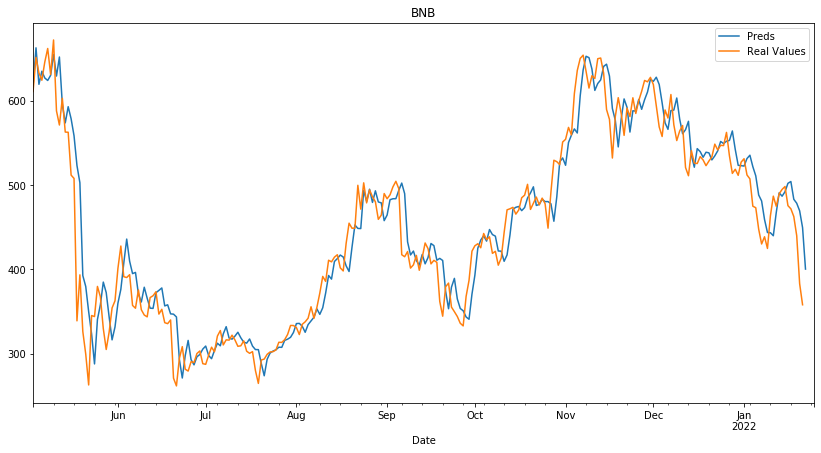

In [94]:
crypto_analyzer.plot_preds_and_real_value(model,X_test,y_test,currency);